# Building Words Model
## 1 - Data Preprocessing

In [2]:
from jupyterthemes import jtplot
jtplot.style('grade3', context='paper')
jtplot.figsize(aspect=1.1)
# jtplot.reset()

In [3]:
from collections import Counter, defaultdict
import csv, json
import random
from time import time

In [95]:
print "[Start Data Preprocessing] ... ..."; t1 = time()

# Reading Training Data
GEO = 0
APP = 1

TOPIC = GEO

content = []
with open('./dataset.txt', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        content.append(row)

with open('./entities_set.json', "r") as f_j:
    ent_with_info = json.load(f_j)
    
with open('./ent_geojson_3377.json', "r") as f_geo:
    ent_geojson = json.load(f_geo)
    
# Input Entity name to locate the entity section in the whole dataset: Entity Name --> Entity ID
name_to_node = defaultdict()
for key in ent_with_info:
    try:
        name_to_node[ent_with_info[key]['tag']['name']] = key
    except:
        continue

##########  
# Labels #
##########

# Acquire the list of labels
labels = []
for item in content:
    labels.append(item[TOPIC])

# Acquire a set of indexes of Positibe and Negative labelled 'docs'
indexes_of_true = [n for n,l in enumerate(labels) if l == 't']
indexes_of_false = [n for n,l in enumerate(labels) if l == 'f']

#############  
# Sentences #
#############

# Acquire raw sentences
sents = []
for item in content:
    sents.append(item[2])
    
# Reading Cleaned Sentences
cleaned_sents = []
with open('./cleaned_sents.csv', 'rb') as f:
    reader = csv.reader(f)
    for row in reader:
        cleaned_sents.append(row)

# Acquire ent for each sentences
ent_sents = []
type_sents = []
for item in content:
    ent_sents.append(item[3])
    try:
        type_sents.append(ent_with_info[item[3]]['ent_type'])
    except:
        type_sents.append([])

############
# POS tags #
############

# Acquire POS tags
pos_sents = []
with open('./training_pos_tag.csv', 'rb') as csvfile:
    spamreader = csv.reader(csvfile)
    for row in spamreader:
        pos_sents.append(row)
        
print '[Finished] --', round((time() - t1), 3), "s"

[Start Data Preprocessing] ... ...
[Finished] -- 3.22 s


## 2 - Loading and Building Word Models

In [5]:
import gensim, logging, os
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
corpus = cleaned_sents[:]
# Reading Word2Vec Model
fname = 'wiki_corpus_300.model'
is_overwrite = 0
if os.path.exists(fname) and is_overwrite == 0:
    # load the file if it has already been trained, to save repeating the slow training step below
    model = gensim.models.Word2Vec.load(fname)
else:
    # can take a few minutes, grab a cuppa
    model = gensim.models.Word2Vec(corpus, size=300, min_count=1, workers=4, iter=50) 
    model.save(fname)

2017-05-21 14:04:18,226 : INFO : loading Word2Vec object from wiki_corpus_300.model
2017-05-21 14:04:18,444 : INFO : loading wv recursively from wiki_corpus_300.model.wv.* with mmap=None
2017-05-21 14:04:18,445 : INFO : loading syn0 from wiki_corpus_300.model.wv.syn0.npy with mmap=None
2017-05-21 14:04:18,594 : INFO : setting ignored attribute syn0norm to None
2017-05-21 14:04:18,601 : INFO : loading syn1neg from wiki_corpus_300.model.syn1neg.npy with mmap=None
2017-05-21 14:04:18,752 : INFO : setting ignored attribute cum_table to None
2017-05-21 14:04:18,753 : INFO : loaded wiki_corpus_300.model


In [40]:
# Loading Pre-built Model
from gensim.models.keyedvectors import KeyedVectors

t1=time()
print "[Loading Model] ... ..."

model_ext_200 = KeyedVectors.load_word2vec_format("/Users/boyachen/Downloads/glove.6B/genism.wikivec_200d", binary= False)
model_ext_300 = KeyedVectors.load_word2vec_format("/Users/boyachen/Downloads/glove.6B/genism.wikivec_300d", binary= False)

print "[Finished!]:", time()-t1, "s"

2017-05-19 16:37:12,621 : INFO : loading projection weights from /Users/boyachen/Downloads/glove.6B/genism.wikivec_200d


[Loading Model] ... ...


2017-05-19 16:38:42,362 : INFO : loaded (400000, 200) matrix from /Users/boyachen/Downloads/glove.6B/genism.wikivec_200d
2017-05-19 16:38:42,363 : INFO : loading projection weights from /Users/boyachen/Downloads/glove.6B/genism.wikivec_300d
2017-05-19 16:40:52,611 : INFO : loaded (400000, 300) matrix from /Users/boyachen/Downloads/glove.6B/genism.wikivec_300d


[Finished!]: 219.991565943 s


In [25]:
cut_num = 17000 # Number of Labelled Docs

words_with_t = []
for i, sent in enumerate(corpus): 
    if labels[i] == 't':
        words_with_t.extend(sent)
words_with_t = list(set(words_with_t))

import numpy as np
from time import time

# sent_matrix = np.array([model[word] for word in cleaned_sents[0] if word in model])
# length = sent_matrix.shape[0]
# dimen = sent_matrix.shape[1]
# center = np.array([sum(sent_matrix[:,i])/(np.var(np.array(sent_matrix[:,i]))) for i in range(dimen)])

vector_model = model
dimen = 300

corpus_matrix = []
t1=time()
for i, sent in enumerate(cleaned_sents[:]):
    try:
        if i % 5000 == 0:
            print i, 'done.'
        if sent == []:
            corpus_matrix.append(np.zeros((1,dimen))[0])
            continue
        sent_matrix = np.array([vector_model[word] for word in sent if word in model])
        length = sent_matrix.shape[0]
        center = [sum(sent_matrix[:,i]) / length for i in range(dimen)]
#         # Lower Dimension
#         if len(center) != 2:
#             center = [max(center), min(center)]
        corpus_matrix.append(center)
    except:
        corpus_matrix.append(np.zeros((1,dimen))[0])

print 'time:', time()-t1

t_dataset = np.array(corpus_matrix[:17000])
t_labels = labels[:17000]

p_dataset = np.array(corpus_matrix[17000:])
# p_labels = labels[17000:]

0 done.
1000 done.
2000 done.
3000 done.
4000 done.
5000 done.
6000 done.
7000 done.
8000 done.
9000 done.
10000 done.
11000 done.
12000 done.
13000 done.
14000 done.
15000 done.
16000 done.
17000 done.
18000 done.
19000 done.
20000 done.
21000 done.
22000 done.
23000 done.
24000 done.
25000 done.
26000 done.
27000 done.
28000 done.
29000 done.
30000 done.
31000 done.
32000 done.
33000 done.
34000 done.
35000 done.
36000 done.
37000 done.
38000 done.
39000 done.
40000 done.
41000 done.
42000 done.
43000 done.
44000 done.
45000 done.
46000 done.
47000 done.
48000 done.
49000 done.
50000 done.
51000 done.
52000 done.
53000 done.
54000 done.
55000 done.
56000 done.
57000 done.
58000 done.
59000 done.
60000 done.
61000 done.
62000 done.
63000 done.
64000 done.
65000 done.
66000 done.
67000 done.
68000 done.
69000 done.
70000 done.
71000 done.
72000 done.
73000 done.
74000 done.
75000 done.
76000 done.
77000 done.
78000 done.
79000 done.
80000 done.
81000 done.
82000 done.
83000 done.
84000

## ! ---------- Imbalance Handling ---------- !

In [123]:
indexes_of_true_r = indexes_of_true[:]
indexes_of_false_r = indexes_of_false[:]
random.shuffle(indexes_of_false_r)
indexes_of_false_r = indexes_of_false_r[:len(indexes_of_true_r) * 3]

indexes_of_r = list(sorted(indexes_of_true_r + indexes_of_false_r))
np.random.shuffle(indexes_of_r) # randomly shuffle the order

t_dataset_r = np.array([t_dataset[i] for i in range(len(t_labels)) if i in indexes_of_r])
t_labels_r = [t_labels[i] for i in range(len(t_labels)) if i in indexes_of_r]

print "size of positive training dataset:", len(indexes_of_true_r)
print "size of negative training dataset:", len(indexes_of_false_r)

size of positive training dataset: 1016
size of negative training dataset: 3048


## 2-d Virsualisation

/Library/Python/2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


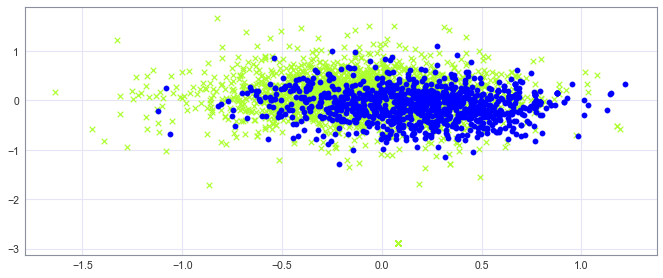

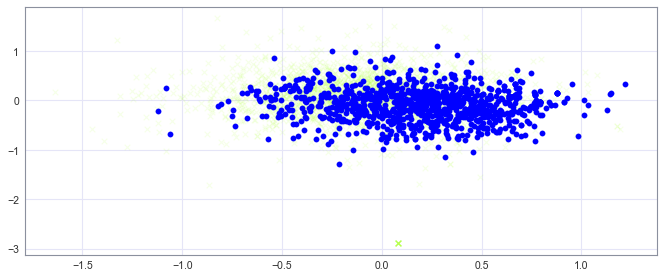

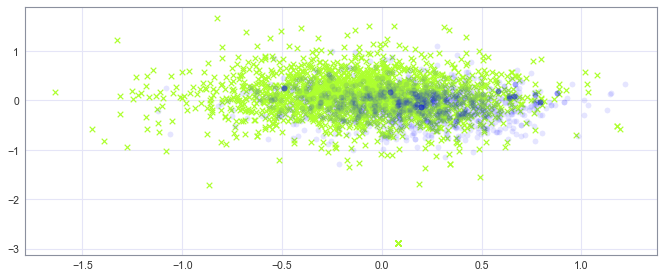

In [53]:
import numpy as np
import matplotlib.pyplot as plt

###########################################################
# True and False
###########################################################

t_database_with_true = []
t_database_with_false = []

for i, item in enumerate(t_dataset_r):
    if t_labels_r[i] == "t":
        t_database_with_true.append(list(item))
    else:
        t_database_with_false.append(list(item))
        
t_database_with_true = np.array(t_database_with_true)
t_database_with_false = np.array(t_database_with_false)

color1 = "greenyellow"
color2 = "blue"

plt.scatter(t_database_with_false[:,0], t_database_with_false[:,1], c=color1, marker='x')
plt.scatter(t_database_with_true[:,0],  t_database_with_true[:,1],  c=color2, marker='o')
plt.show()

# Highlit Different Classes
plt.scatter(t_database_with_false[:,0], t_database_with_false[:,1], c=color1, marker='x', alpha=0.1)
plt.scatter(t_database_with_true[:,0],  t_database_with_true[:,1],  c=color2, marker='o')
plt.show()

plt.scatter(t_database_with_false[:,0], t_database_with_false[:,1], c=color1, marker='x' )
plt.scatter(t_database_with_true[:,0],  t_database_with_true[:,1],  c=color2, marker='o', alpha=0.1)
plt.show()

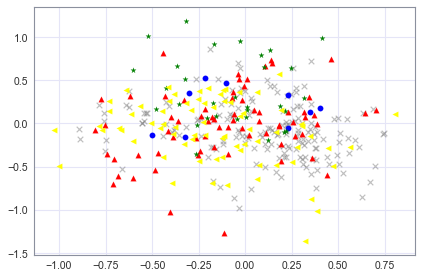

In [92]:
###########################################################
# Classied as in terms of types (2D only)
###########################################################

t_database_type_tourism = []
t_database_type_pub_trapt = []
t_database_type_ament = []
t_database_type_natrual = []
t_database_type_other = []
for i, item in enumerate(t_dataset):
    if type_sents[i] == ['tourism'] and labels[i] == 't':
        t_database_type_tourism.append(list(item))
    elif type_sents[i] == ['public_transport'] and labels[i] == 't':
        t_database_type_pub_trapt.append(list(item))
    elif type_sents[i] == ['amenity'] and labels[i] == 't':
        t_database_type_ament.append(list(item))
    elif type_sents[i] == ['natural'] and labels[i] == 't':
        t_database_type_natrual.append(list(item))
    elif labels[i] == "t":
        t_database_type_other.append(list(item))
t_database_type_tourism = np.array(t_database_type_tourism)
t_database_type_pub_trapt = np.array(t_database_type_pub_trapt)
t_database_type_other = np.array(t_database_type_other)
t_database_type_ament = np.array(t_database_type_ament)
t_database_type_natrual = np.array(t_database_type_natrual)

plt.scatter(t_database_type_other[:,0], t_database_type_other[:,1], c='grey', marker='x', alpha=0.5)
plt.scatter(t_database_type_tourism[:,0], t_database_type_tourism[:,1], c='red', marker='^')
plt.scatter(t_database_type_pub_trapt[:,0], t_database_type_pub_trapt[:,1], c='blue', marker='o')
plt.scatter(t_database_type_ament[:,0], t_database_type_ament[:,1], c='green', marker='*')
plt.scatter(t_database_type_natrual[:,0], t_database_type_natrual[:,1], c='yellow', marker='<')

plt.show()

## Visualizing Multidimensional Data in Python
- Method 1: Two-dimensional slices
- Method 2: PCA Plotting
- Method 3: Linear Discriminant Analysis
- Method 4: Parallel Coordinates

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets.samples_generator import make_blobs

from pandas.tools.plotting import parallel_coordinates, andrews_curves

# Multi-dimension vector normalisation
def x_norm(array):
    return (array - min(array)) / (max(array) - min(array)) if (max(array) - min(array)) !=0 else array

### Method 2: PCA Plotting

Principle Component Analysis (PCA) is a method of dimensionality reduction. It has applications far beyond visualization, but it can also be applied here. It uses eigenvalues and eigenvectors to find new axes on which the data is most spread out. From these new axes, we can choose those with the most extreme spreading and project onto this plane. (This is an extremely hand-wavy explanation; I recommend reading more formal explanations of this.)

In Python, we can use PCA by first fitting an sklearn PCA object to the normalized dataset, then looking at the transformed matrix.

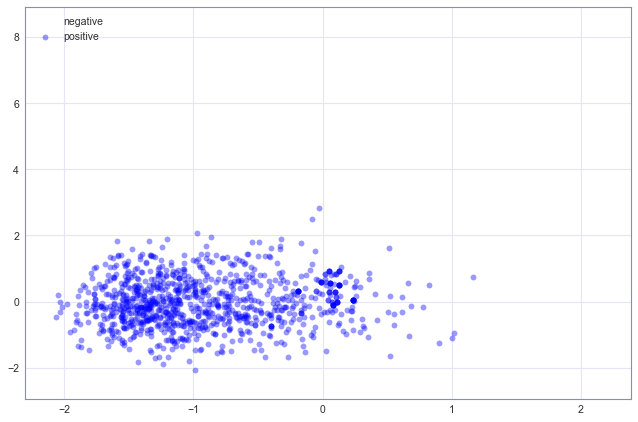

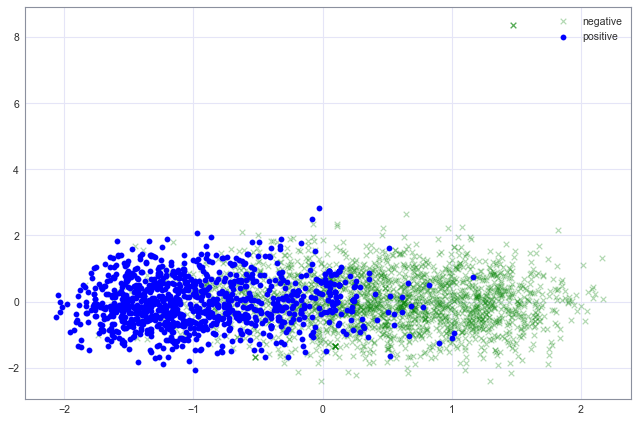

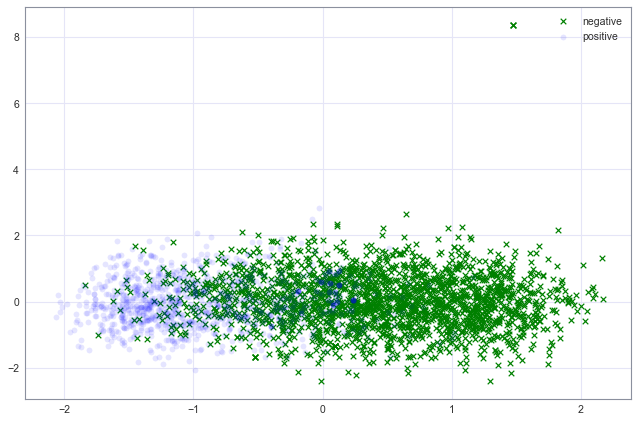

In [120]:
jtplot.figsize(9,6)

t_dataset_norm = np.array([x_norm(r) for r in t_dataset_r])

pca = sklearnPCA(n_components=2)
transformed = pca.fit_transform(t_dataset_norm)

transformed_true = []
transformed_false = []
for i in range(len(transformed)):
    if t_labels_r[i] == "t":
        transformed_true.append(list(transformed[i]))
    else:
        transformed_false.append(list(transformed[i]))
transformed_true = np.array(transformed_true)
transformed_false = np.array(transformed_false)

color1, marker1 = "green", 'x'
color2, marker2 = "blue", 'o'

plt.scatter(transformed_false[:,0], transformed_false[:,1], label = "negative", c=color1, marker=marker1, alpha=0)
plt.scatter(transformed_true[:,0], transformed_true[:,1], label = "positive", c=color2, marker=marker2, alpha = 0.4)

plt.legend(loc=2)
plt.show()

plt.scatter(transformed_false[:,0], transformed_false[:,1], label = "negative", c=color1, marker=marker1, alpha = 0.3)
plt.scatter(transformed_true[:,0], transformed_true[:,1], label = "positive", c=color2, marker=marker2)

plt.legend()
plt.show()

plt.scatter(transformed_false[:,0], transformed_false[:,1], label = "negative", c=color1, marker=marker1)
plt.scatter(transformed_true[:,0], transformed_true[:,1], label = "positive", c=color2, marker=marker2, alpha = 0.1)

plt.legend()
plt.show()

In [105]:
jtplot.figsize(6,4)

color2 = "blue"

for ran in range(10):
    plt.scatter(transformed_true[:(ran+1)*100,0], transformed_true[:(ran+1)*100,1], label = "positive", c=color2, marker=marker2, alpha = 0.3)
    plt.legend(loc=2)
    plt.show()

In [116]:
# for i, arr in enumerate(transformed):
#     if -5 < arr[0] < -3 and -0.25 < arr[1] < 0.25 and labels[indexes_of_r[i]] == 'f':
#         print indexes_of_r[i], "|", labels[indexes_of_r[i]], "|",  sents[indexes_of_r[i]]

### Method 3: Linear Discriminant Analysis

A similar approach to projecting to lower dimensions is Linear Discriminant Analysis (LDA). This is similar to PCA, but (at an intuitive level) attempts to separate the classes rather than just spread the entire dataset.

The code for this is similar to that for PCA:

### Method 4: Parallel Coordinates

The final visualization technique I’m going to discuss is quite different than the others. Instead of projecting the data into a two-dimensional plane and plotting the projections, the Parallel Coordinates plot (imported from pandas instead of only matplotlib) displays a vertical axis for each feature you wish to plot. Each sample is then plotted as a color-coded line passing through the appropriate coordinate on each feature. While this doesn’t always show how the data can be separated into classes, it does reveal trends within a particular class. (For instance, in this example, we can see that Class 3 tends to have a very low OD280/OD315.)

In [104]:
# || Method 4 ||: Parallel Coordinates
# df = pd.concat([pd.DataFrame(t_dataset_r[:,:30]), pd.DataFrame(t_labels_r, columns=["label"])], axis=1)
# parallel_coordinates(df, "label", colormap="summer")
# plt.show()

# Validation

In [125]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report

def check_results(predictions, classifications):
    lab = ['t', 'f']
#     print "accuracy"
#     print accuracy_score(classifications, predictions)
    print classification_report(classifications, predictions, labels=lab)

############################
# Classifiers from Sklearn #
############################
# # Naive Bayes
from sklearn.naive_bayes import MultinomialNB
clf_nb = MultinomialNB()

# # Support Vector Machine
from sklearn import svm
clf_svm = svm.LinearSVC(C=0.1)

# # Decision Tree
from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier()
# # Random Foreset Classifier
from sklearn.ensemble import RandomForestClassifier
clf_rfc = RandomForestClassifier()
# # Bagging Classifier
from sklearn.ensemble import BaggingClassifier
clf_bag = BaggingClassifier()

# # K Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier
clf_knc = KNeighborsClassifier(n_neighbors=3)

test_clf = [clf_svm, clf_rfc, clf_knc]

t1 = time()
print "[Job Start]"
for clf in test_clf:
#     print 'CLASSIFIER -->', str(clf)
#     print '------- CROSS VALIDATION --------'
    crossval_predicted = cross_val_predict(clf, t_dataset_r, t_labels_r, cv=20)
    check_results(crossval_predicted, t_labels_r)
    print '----------------------------------------------------'
    print '\n'
    
print "[Job Done]:", time()-t1, "s"

[Job Start]
             precision    recall  f1-score   support

          t       0.82      0.84      0.83      1016
          f       0.95      0.94      0.94      3048

avg / total       0.91      0.91      0.91      4064

----------------------------------------------------


             precision    recall  f1-score   support

          t       0.88      0.71      0.79      1016
          f       0.91      0.97      0.94      3048

avg / total       0.90      0.90      0.90      4064

----------------------------------------------------


             precision    recall  f1-score   support

          t       0.82      0.86      0.84      1016
          f       0.95      0.94      0.94      3048

avg / total       0.92      0.92      0.92      4064

----------------------------------------------------


[Job Done]: 32.9004089832 s


In [26]:
def error_checking(real_predictions, labels, verbose):
    t_t = len([i for i in range(len(real_predictions)) if real_predictions[i] == 't' and labels[i] == 't'])
    f_f = len([i for i in range(len(real_predictions)) if real_predictions[i] == 'f' and labels[i] == 'f'])
    t_f = len([i for i in range(len(real_predictions)) if real_predictions[i] == 'f' and labels[i] == 't'])
    f_t = len([i for i in range(len(real_predictions)) if real_predictions[i] == 't' and labels[i] == 'f'])

    print '--Correct--'
    print 'True --> True:', t_t 
    print 'False --> False:', f_f
    print ''
    print '--Incorrect--'
    print 'True --> False:', t_f
    print 'False --> True:', f_t
    print ''
    print '--> Accuracy:', round((t_t+f_f) / float(t_t+t_f+f_t+f_f) , 2)
    print '--> Precision:', round(t_t / float(t_t+f_t) , 2 )
    print '--> Recall:', round(t_t / float(t_t+t_f), 2 )
    print ''
    
    test_case = [l for l in verbose]
    print "Sentence: ",test_case[0],"-->",test_case[1]
    print "-" * 80
    for i, sent in enumerate(sents[:len(real_predictions)]):
        if real_predictions[i] == test_case[1] and labels[i] == test_case[0]:
            print '>', i, '\t|  ', sent

if_train_clf = 1
if if_train_clf == 1:
    real_predictions = clf_rfc.fit(t_dataset_r, t_labels_r).predict(p_dataset)

## Real World - Prediction

In [85]:
import json
import math
import nltk
import wikipedia as wk
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
from nltk.corpus import stopwords
stpwords = stopwords.words()

def lemmatize(word):
    lemma = lemmatizer.lemmatize(word,'v')
    if lemma == word:
        lemma = lemmatizer.lemmatize(word,'n')
    return lemma

In [103]:
# # 1 | Read Article (using wikipedia-python API)

# # res = wk.page("melbourne university")
# article = res.content.split("\n")
# # text-preprocessing
# article = [nltk.word_tokenize(line) for line in article if line != ""]



# article = [nltk.word_tokenize(line) for line in article if line != ""]
# article



In [39]:
# ent_with_sents = defaultdict();
# for r, l in enumerate(t_labels):
#     if l == "t":
#         ent_id = ent_sents[r]
#         if ent_id in ent_with_sents:
#             ent_with_sents[ent_id].append(sents[r])
#         else:
#             ent_with_sents[ent_id] = []
#             ent_with_sents[ent_id].append(sents[r])
    
# for r, p in enumerate(real_predictions):
#     if p == "t":
#         ent_id = ent_sents[r+17000]
#         if ent_id in ent_with_sents:
#             ent_with_sents[ent_id].append(sents[r+17000])
#         else:
#             ent_with_sents[ent_id] = []
#             ent_with_sents[ent_id].append(sents[r+17000])
# #         print ">", r+17000, "|", ent_sents[r+17000], "|", sents[r+17000], "|"

In [62]:
ent_geojson_dict = defaultdict()
for row, item in enumerate(ent_geojson['features']):
    ent_geojson_dict[item['properties']['name']] = row
ent_geojson_dict

defaultdict(None,
            {u'Harding River': 1397,
             u'Woody Lake': 1228,
             u'Fivebough Swamp': 1517,
             u'Blacktown': 4,
             u'Eyre Park': 2005,
             u'Valentine Falls': 3182,
             u'Molonglo River': 2257,
             u'South Albury': 2832,
             u'Australian Academy of Science': 2216,
             u'Glass Creek': 2353,
             u'Quakers Hill High School': 263,
             u'Lake Burrumbeet': 293,
             u'Broome Regional Prison': 391,
             u'Seacombe Heights': 948,
             u'Gosse Bluff': 2902,
             u'The Block Arcade': 782,
             u'Lake Purrumbete': 652,
             u'Dimbulah': 1476,
             u'Wollongong Central': 1942,
             u'Hindley Street': 2794,
             u'Padbury Senior High School': 820,
             u'Smiths Gully': 811,
             u'Sydney Cricket Ground': 1601,
             u'Gundagai': 3369,
             u'Capricornia Cays National Park': 158,
 

In [57]:
for name in name_to_node:
    try:
        sents = ent_with_sents[name_to_node[name]]
        index = ent_geojson_dict[name]
        ent_geojson['features'][index]['properties']['sentences'] = sents
        print ent_geojson_dict[name], "|", name, "|", sents
        print
    except:
        print name, "|", "---"
        print

1397 | Harding River | ['The Harding River is a river in the Pilbara of Western Australia.', 'The river flows through Lake Poongkaliyarra and out through Lockyer Gap.', 'The river continues northward and crosses the North West Coastal Highway near Roebourne then discharges into the Indian Ocean via Butcher Inlet.', 'Th river has six tributaries; Harding River East, East Harding River, Murray Camp Creek and Miller Creek.']

1228 | Woody Lake | ['Woody Lake is a salt lake in the Goldfields-Esperance region of Western Australia found approximately 7 kilometres (4 mi) north east of Esperance.', 'The lake is found between Lake Wheatfield to the east and Windabout Lake to the west.', 'The reserve incorporates most of Windabout Lake, Woody Lake and Wheatfield Lake.', 'The wetlands are connected by a series of channels with surface water from Coramup Creek entering the system at Lake Wheatfield and the outflow moving from east to west through Lake Wheatfield directly into Woody Lake via a well

3168 | South Bingera | ['South Bingera is a locality in the Bundaberg Region, Queensland, Australia.', 'It is 16 kilometres (9.9 mi) south-west of Bundaberg on the Isis Highway.']

Rifle Creek Dam | ---

Bellevue Heights | ---

Melbourne General Cemetery | ---

Kurunjang Secondary College | ---

950 | Kanangra Falls | ['Kanangra Falls is a waterfall on the Kanangra River, in the Kanangra-Boyd National Park, near Oberon, in the Central Tablelands of New South Wales, Australia.', 'The waterfall is located at Thurat Walls about 800 metres (2,600 ft) north east of Ianthe Hill; with the fall height reported in 1930 as being 225 metres (738 feet) in two sections.']

Japanese School of Melbourne | ---

Immigration Museum | ---

217 | Mill Valley Ranch | ['Mill Valley Ranch is a Christian Youth Camp in Tynong North, 70 km (43 mi) South East of Melbourne, Victoria, Australia.']

1826 | Busselton Airport | ["Busselton Regional Airport (IATA: BQB, ICAO: YBLN) is located 6.5 km (4.0 mi) from Busse

1464 | Grose River | ['The Grose River, a perennial river that is part of the Hawkesbury-Nepean catchment, is located in the Blue Mountains region of New South Wales, Australia.', '== Course and features == The Grose River rises from north east of Mount Victoria within the Blue Mountains National Park, and flows through the Grose Valley and parts of the Greater Blue Mountains Area World Heritage Site, generally north, southeast, the', 'The valley is located between the Great Western Highway and Bells Line of Road, the two major routes across the Blue Mountains.', 'The majority of the valley falls within the Blue Mountains National Park.']

2751 | Seafarers Bridge | ['The Seafarers Bridge is a footbridge over the Yarra River between Docklands and South Wharf in Melbourne, Victoria, Australia.', 'The bridge connects the north and south banks of the river while providing a formal entrance to the Melbourne Convention and Exhibition Centre.']

607 | Patawalonga River | ['The River is servic

2747 | Dunk Island | ['Dunk Island is an island within the Cassowary Coast Region, Queensland, Australia.', 'The island lies 4 km off the Australian east coast, opposite the town of Mission Beach.', 'The shores are rocky on one side and sandy on the other, where a low point runs out to the westward.']

3362 | Falcon Island | ['Falcon Island is one of the islands in the Great Palm Island group, off the eastern coast of Queensland, Australia.']

976 | Hellyers Road Distillery | ['Hellyers Road is a whisky distillery in Burnie, Tasmania.']

Thornlie Senior High School | ---

643 | Park 26 | ['Most of the parks are more commonly known by a commemorative name, but some, particularly Park 10, are still known mostly by their number.', 'The southern and western boundaries are provided by War Memorial Drive.', 'The eastern boundary, from south to north, is formed by Montefiore Rd, the western end of North Adelaide (i.e.', "=== Park 2 === Padipadinyilla 'swimming place' 17 hectares Approximately

Laanecoorie Weir | ---

2954 | Newstead College | ['Newstead College is situated in Launceston, Tasmania, Australia.']

2834 | Goodradigbee River | ['== Course and features ==  The river rises below Mount Morgan on the northern side of the Snowy Mountains at 1,650 metres (5,410 ft) and flows generally north west, joined by fifteen minor tributaries towards its mouth at the confluence with the Murrumbid', 'Some water from the upper reaches of the river is diverted into Tantangara Reservoir via an aqueduct, but otherwise the river is not dammed.']

1018 | Brunswick Town Hall | ['Brunswick Town Hall is located on the corner of Sydney Road and Dawson Street in the inner northern Melbourne suburb of Brunswick, Victoria, Australia.']

139 | Staghorn Flat | ['Staghorn Flat is a rural locality in the Yackandandah Valley of north east Victoria, situated between Wodonga and Yackandandah.']

878 | Noosa National Park | ['Noosa National Park is a national park in Queensland, Australia, 121 km nort

1933 | Koolan Island | ['Koolan Island is an island off the Kimberley coast of Western Australia in the Buccaneer Archipelago.', 'It is about 1,900 km (1,181 miles) north of Perth, and about 130 km (81 mi) north of Derby.']

705 | HMAS Creswell | ['== Location == HMAS Creswell is located between Jervis Bay Village and Greenpatch on the shores of Jervis Bay in the Jervis Bay Territory.']

1544 | Bremer State High School | ['Bremer State High School (Bremer SHS) is a public, co-educational high school located in Ipswich, Queensland.']

1101 | Applecross Senior High School | ['Applecross Senior High School is a public, co-educational High School, located in Ardross, a southern suburb of Perth, Western Australia.']

3108 | Victorian Goldfields Railway | ['1 km).']

Eildon Mansion | ---

Dapto Mall | ---

1508 | Picton Road | ['Picton Road is a New South Wales highway linking Picton and Wollongong.', 'From Picton, the highway runs in the southeastern direction, crosses the Hume Highway and 

1252 | Annan River | ['Annan River National Park is a national park on Cape York Peninsula in Far North Queensland, Australia.', 'The Annan River from which the park gets it name, marks the northern and western extent of the park.', 'To the east of the park is Walker Bay in the Coral Sea.', 'Annan River National Park lies within the Cape York Peninsula and Wet Tropics of Queensland bioregions.', '== Facilities == The park has no facilities.']

Jack Pesch Bridge | ---

Australian Butterfly Sanctuary | ---

749 | Helensvale | ['Helensvale is a suburb on the Gold Coast in Queensland, Australia and was named after Helena White.', 'The Gold Coast Highway and Pacific Motorway, the two most important road routes on the Gold Coast, link here.']

1019 | Corin Dam | ['The Corin Dam is an earth and rockfill embankment dam with an uncontrolled side channel spillway across the Cotter River, located within Namadgi National Park in the Australian Capital Territory, Australia.']

303 | Christ Church G

772 | Jane Brook | ['== Suburb == It is also the name of the middle class suburb, situated approximately 25 kilometers east of the capital city Perth, Western Australia.', 'The nearest major shopping precinct is located in Midland, approximately 5 km to the west.']

1955 | Mount Tambo | ['Mount Tambo is a mountain located to the north-east of Omeo in Victoria, Australia.']

3273 | Walpole River | ['The Walpole River is a river in the Great Southern region of Western Australia.']

214 | Dakabin State High School | ['Dakabin State High School is a large secondary school located at Dakabin, north of Brisbane, Queensland, Australia.']

3130 | Stewarts River | ['Stewarts River, a mostly perennial stream of the Mid North Coast region, is located in New South Wales, Australia.', '== Course and features == Stewarts River rises on the northern slopes of Big Nellie within Coorabakh National Park, west of the village of Hannam Vale, and flows generally east by south and then east, joined by the C

# Output the Results for web-app

In [41]:
# import wikipedia as wp
# for i, key in enumerate(name_to_node):
#     print i, "/", len(name_to_node)
#     if "coordinates" in ent_with_info[name_to_node[key]].keys():
#         continue
#     try:
#         page = wp.page(key)
#         coord = page.coordinates
#         lon = round(coord[1], 8)
#         lat = round(coord[0], 8)
#         ent_with_info[name_to_node[key]]["coordinates"] = (lon, lat)
#         print name_to_node[key], "|", key, "|", (lon, lat)
#     except KeyError:
#         print "[error]: no coord", key
#     except:
#         print "[error]:", key

In [59]:
path = "./ent_geojson_3377_with_sents.json"
with open(path, "w") as output:
    json.dump(ent_geojson, output)